In [1]:
import netCDF4 as nc
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rcParams['font.sans-serif'] = "Calibri"
# mpl.rcParams['font.size'] = 6
plt.rc('font',family='Arial',size=8)
# Setting mathfont-------------------------------------
from matplotlib import rcParams
config = {"mathtext.fontset":'stix',}
rcParams.update(config)
# -----------------------------------------------------
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.utils import shuffle
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.dates as mdates
import matplotlib.patches as patches
import os
import math 
from scipy import ndimage
import matplotlib.ticker as mticker
from matplotlib.ticker import MultipleLocator 
import matplotlib.dates as mdates
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
import cartopy.io.shapereader as shpreader
from pylab import *
import time
import datetime
from scipy import interpolate
import metpy.calc as mpcalc
from metpy.units import units
from skimage import transform
from scipy.stats.mstats import ttest_ind
import cmaps 
plt.close() 

# 1. First figure

In [ ]:
'''
-------------------------------------------------------------------------------------- 
Calculate area-weighted t2m_ano
-------------------------------------------------------------------------------------- 
'''
### Read t2m_ano ###
input_dir = '../data/era5_single-level/2m_temperature'
files_ls = [f'{input_dir}/era5_single_2m_temperature_{year}.nc' for year in np.arange(1979,2024,1)]
ds = xr.open_mfdataset(files_ls)
t2m_1979to2023_Dec = ds['t2m'].sel(time=ds['time.month'].isin([12])).compute()

### Calculate weighted-area t2m_ano in north ###
weights = np.cos(np.deg2rad(t2m_1979to2023_Dec ['latitude']))
t2m_Dec_clim_north = t2m_1979to2023_Dec.loc[:,39:33,106:114].weighted(weights).mean(dim=('latitude','longitude')).groupby('time.day').mean('time')
t2m_Dec_std_north = t2m_1979to2023_Dec.loc[:,39:33,106:114].weighted(weights).mean(dim=('latitude','longitude')).groupby('time.day').std('time')
t2m_Dec_2023_north = t2m_1979to2023_Dec.loc['2023-12-01':'2023-12-31'].loc[:,39:33,106:114].weighted(weights).mean(dim=('latitude','longitude'))

t2m_ano_Dec_2023_north = t2m_Dec_2023_north - t2m_Dec_clim_north.values
t2m_StdAno_Dec_2023_north = t2m_ano_Dec_2023_north / t2m_Dec_std_north.values

### Calculate weighted-area t2m_ano in south ###
weights = np.cos(np.deg2rad(t2m_1979to2023_Dec ['latitude']))
t2m_Dec_clim_south = t2m_1979to2023_Dec.loc[:,31:25,104:116].weighted(weights).mean(dim=('latitude','longitude')).groupby('time.day').mean('time')
t2m_Dec_std_south = t2m_1979to2023_Dec.loc[:,31:25,104:116].weighted(weights).mean(dim=('latitude','longitude')).groupby('time.day').std('time')
t2m_Dec_2023_south = t2m_1979to2023_Dec.loc['2023-12-01':'2023-12-31'].loc[:,31:25,104:116].weighted(weights).mean(dim=('latitude','longitude'))

t2m_ano_Dec_2023_south = t2m_Dec_2023_south - t2m_Dec_clim_south.values
t2m_StdAno_Dec_2023_south = t2m_ano_Dec_2023_south / t2m_Dec_std_south.values

In [ ]:
'''
-------------------------------------------------------------------------------------- 
Read the WWEs-num files
-------------------------------------------------------------------------------------- 
'''

ds = xr.open_dataset('../data/WWEs_num/WWEs_num_Dec1979to2023_24-hour.nc')
WWEs_cold_norm_24h = ds['WWEs_cold_perDec_norm']
WWEs_warm_norm_24h = ds['WWEs_warm_perDec_norm']
WWEs_cold_perDec_24h = ds['WWEs_cold_perDec']

ds = xr.open_dataset('../data/WWEs_num/WWEs_num_Dec1979to2023_48-hour.nc')
WWEs_cold_norm_48h = ds['WWEs_cold_perDec_norm']
WWEs_warm_norm_48h = ds['WWEs_warm_perDec_norm']
WWEs_cold_perDec_48h = ds['WWEs_cold_perDec']

ds = xr.open_dataset('../data/WWEs_num/WWEs_num_Dec1979to2023_72-hour.nc')
WWEs_cold_norm_72h = ds['WWEs_cold_perDec_norm']
WWEs_warm_norm_72h = ds['WWEs_warm_perDec_norm']
WWEs_cold_perDec_72h = ds['WWEs_cold_perDec']

In [ ]:
'''
-------------------------------------------------------------------------------------- 
Calculate area-weighted WWEs_cold
-------------------------------------------------------------------------------------- 
'''

def calc_WWEs_cold(interval_hour):
    '''
    Read data
    '''
    input_dir = '../data/era5_single-level/2m_temperature'
    files_ls = [f'{input_dir}/era5_single_2m_temperature_{year}.nc' for year in np.arange(1978,2024,1)]
    ds = xr.open_mfdataset(files_ls)
    t2m_1978to2023 = ds['t2m'].compute()


    '''
    Calculate t2m_diff
    '''
    t2m_1979to2023 = t2m_1978to2023.loc['1979-01-01':'2023-12-31']
    time_array = t2m_1979to2023['time']
    new_time_array = time_array - pd.Timedelta(hours=interval_hour)
    t2m_1979to2023_neg = t2m_1978to2023.sel(time=new_time_array)
    t2m_1979to2023_diff = t2m_1979to2023 - t2m_1979to2023_neg.values
    t2m_1979to2023_diff_nofeb29 = t2m_1979to2023_diff.sel(time=~((t2m_1979to2023_diff['time.month'] == 2) & (t2m_1979to2023_diff['time.day'] == 29)))


    '''
    Calculate WWEs during Dec
    '''
    t2m_1979to2023_diff_Dec = t2m_1979to2023_diff_nofeb29.sel(time=t2m_1979to2023_diff_nofeb29['time.month'].isin([12]))
    ### cold ###
    quantile_05 = t2m_1979to2023_diff_Dec.quantile(0.05,dim='time')
    WWEs_cold = xr.where(t2m_1979to2023_diff_Dec<=quantile_05,1,0)

    return WWEs_cold


def calc_WeightAve_WWEs(WWEs_cold):
    WWEs_cold_2023Dec = WWEs_cold.sel(time=WWEs_cold['time.year']==2023)
    weights = np.cos(np.deg2rad(WWEs_cold_2023Dec['latitude']))

    area_north_WWEs = WWEs_cold_2023Dec.loc[:,39:33,106:114].weighted(weights).sum(dim=('latitude', 'longitude'))
    area_north_total = xr.ones_like(WWEs_cold_2023Dec, dtype=float32).loc[:,39:33,106:114].weighted(weights).sum(dim=('latitude', 'longitude'))
    ratio_north_WWEs = area_north_WWEs / area_north_total * 100

    area_south_WWEs = WWEs_cold_2023Dec.loc[:,31:25,104:116].weighted(weights).sum(dim=('latitude', 'longitude'))
    area_south_total = xr.ones_like(WWEs_cold_2023Dec, dtype=float32).loc[:,31:25,104:116].weighted(weights).sum(dim=('latitude', 'longitude'))
    ratio_south_WWEs = area_south_WWEs / area_south_total * 100

    return ratio_north_WWEs, ratio_south_WWEs


WWEs_cold_72h = calc_WWEs_cold(72)
ratio_north_WWEs_72h, ratio_south_WWEs_72h = calc_WeightAve_WWEs(WWEs_cold_72h)

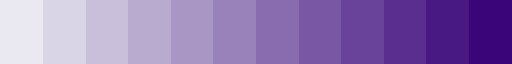

In [15]:
from pylab import *
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
clist=['#eae9f2', '#390578']
newcmp = LinearSegmentedColormap.from_list('chaos',clist,N=12)
newcmp

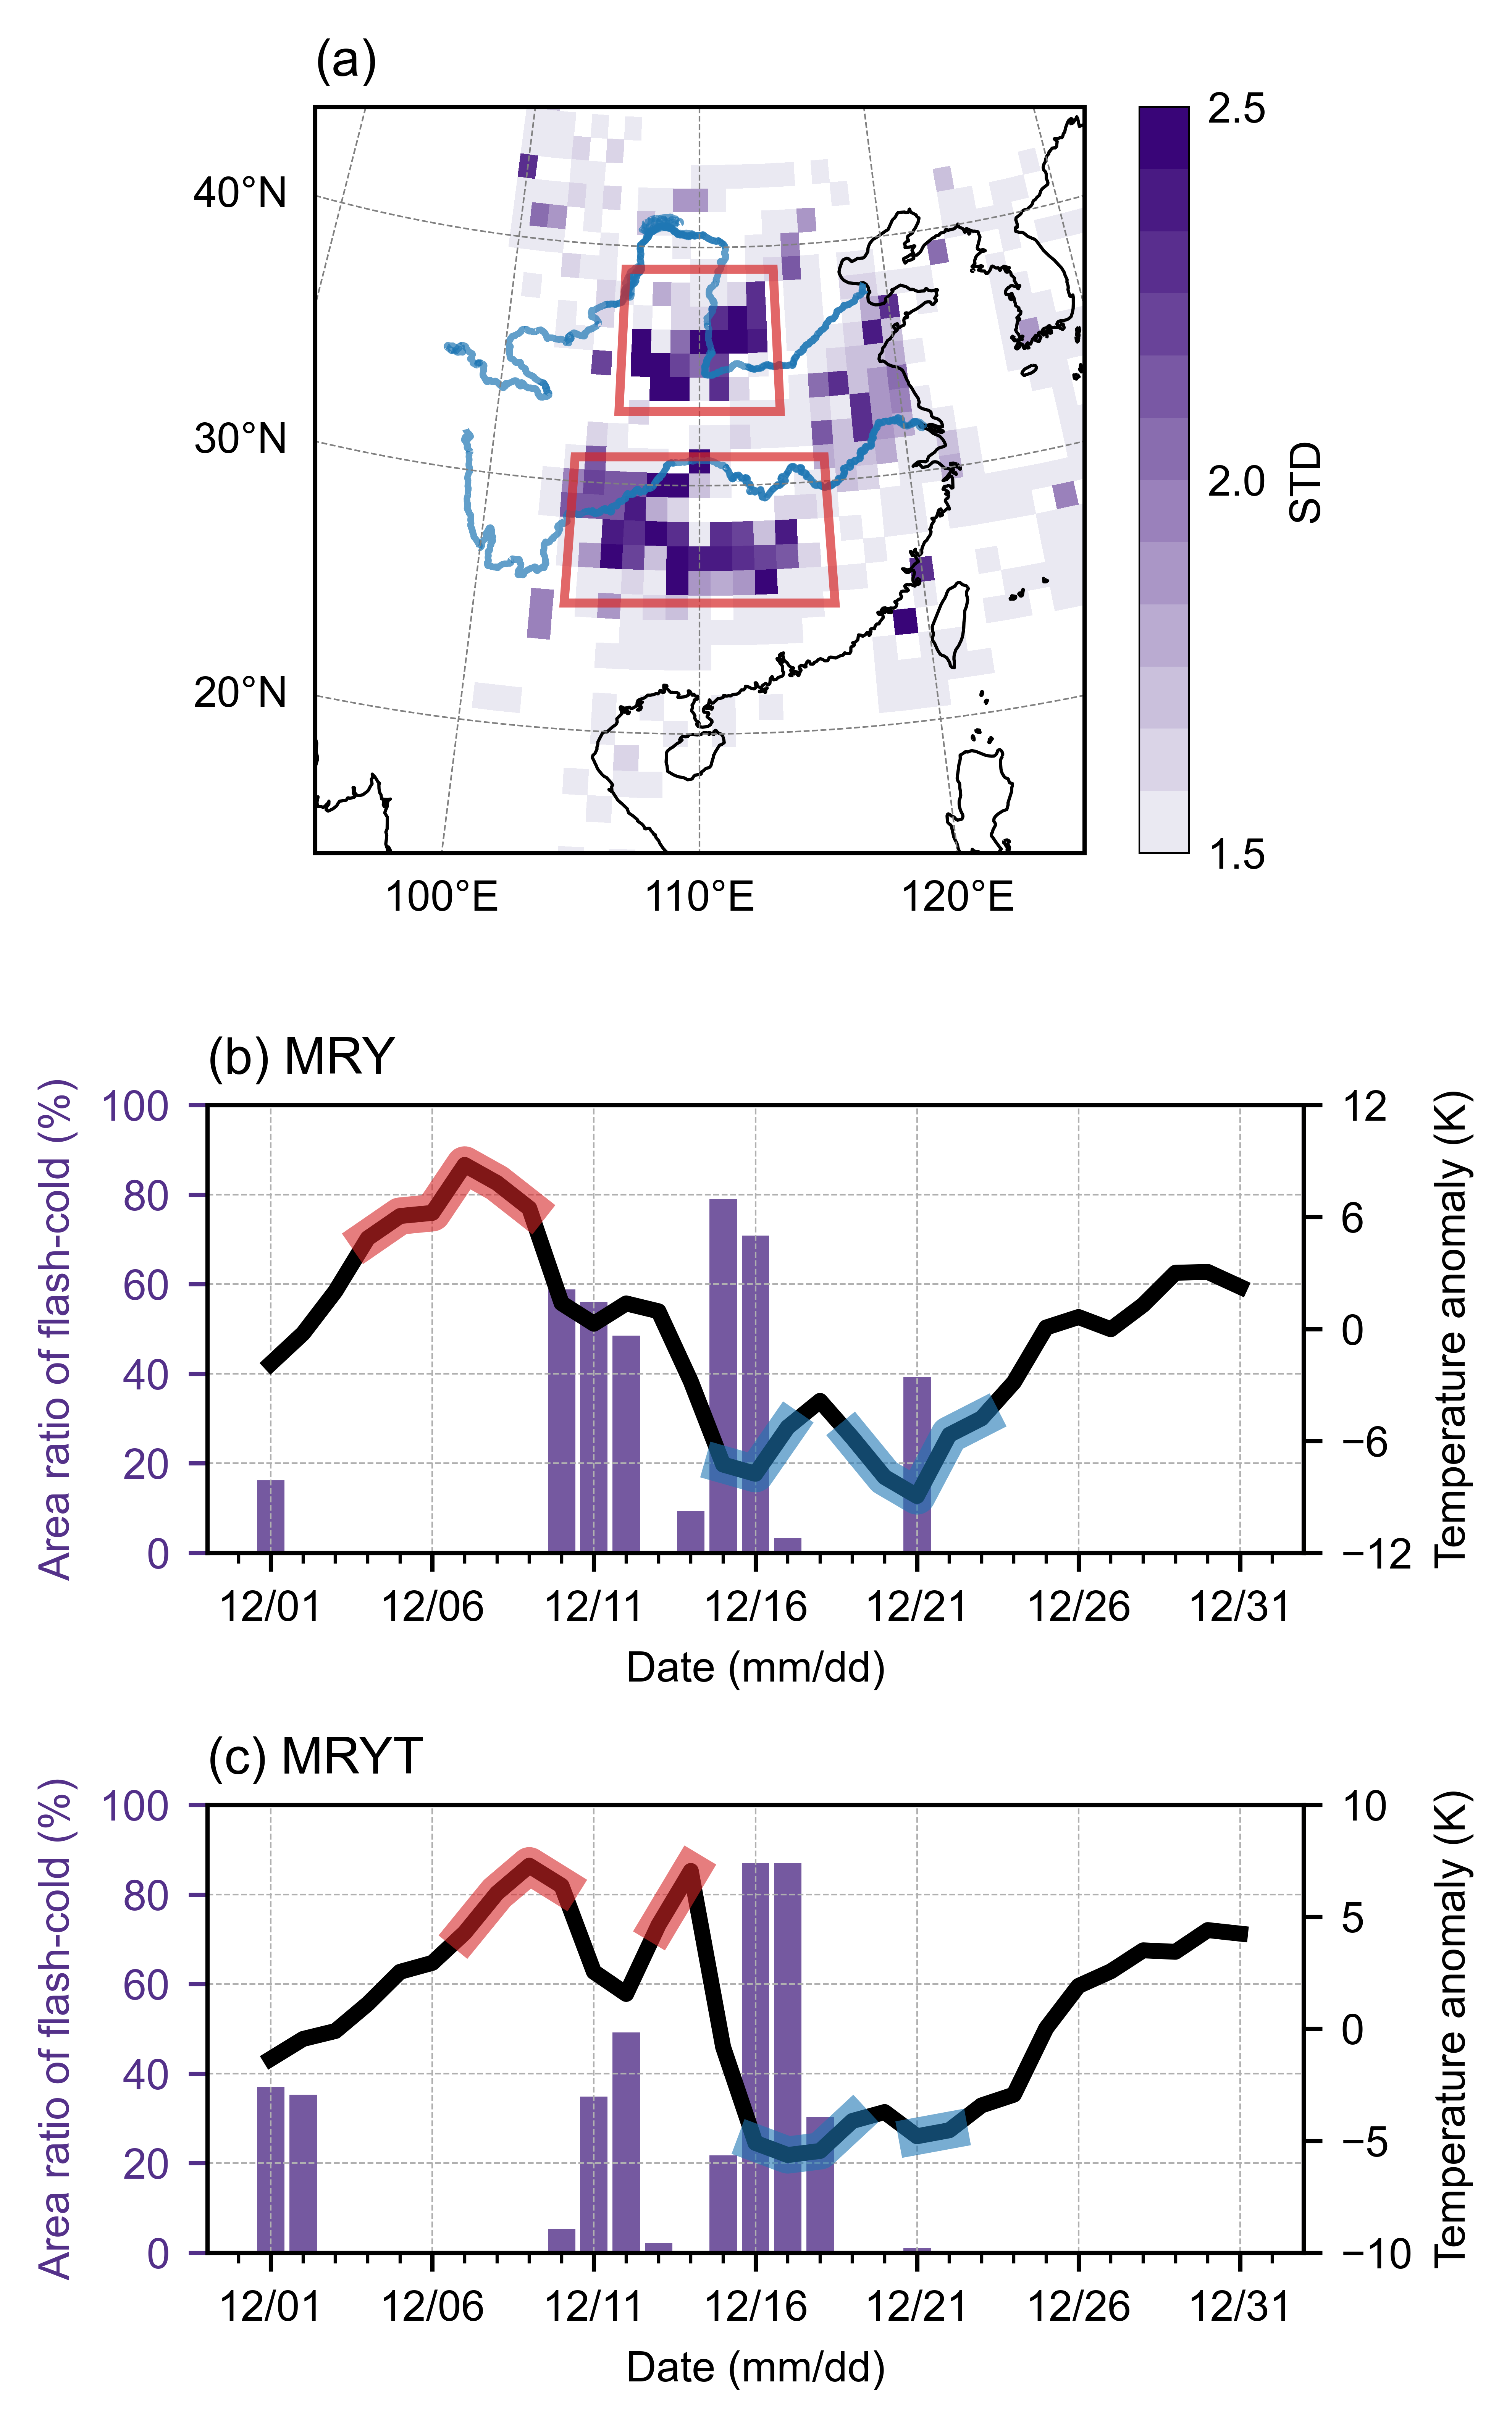

In [16]:
'''
-------------------------------------------------------------------------------------- 
Draw the picture
-------------------------------------------------------------------------------------- 
'''

x_ticks = pd.to_datetime(ratio_north_WWEs_72h['time.date']).strftime('%m/%d')
t2m_ano_ls = [t2m_ano_Dec_2023_north, t2m_ano_Dec_2023_south]
t2m_StdAno_ls = [t2m_StdAno_Dec_2023_north, t2m_StdAno_Dec_2023_south]
t2m_ano_yticks_ls = [np.linspace(-12,12,5), np.linspace(-10,10,5)]
ratio_ls = [ratio_north_WWEs_72h, ratio_south_WWEs_72h]

row_num = 3
col_num = 1
fig, axs = plt.subplots(row_num, col_num, figsize=(5*0.8,8*0.8), gridspec_kw={'height_ratios':[2,1.2,1.2]}, dpi=1000)

ax = axs[0]
projection = ccrs.LambertConformal(central_longitude=110,central_latitude=45,standard_parallels=(30,60))
data_ccrs = ccrs.PlateCarree()
ax.axis('off')
##Some attrs of map##
ax = fig.add_subplot(3, 1, 1, projection=projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), lw=0.6, edgecolor='black') 
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='None') 
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='None') 
# import river
shp_path = '../data/shp-file/lev1-river'                        
shp_data = shpreader.Reader(shp_path)
for s in shp_data.records():
    if s.attributes['NAME'] in ['黄河','长江','金沙江']:
        ax.add_geometries([s.geometry], data_ccrs, facecolor='none', edgecolor='tab:blue', alpha=0.7, lw=1.2)

ax.set_extent([95, 125, 15, 45], data_ccrs)

gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, linestyle='--', color='grey', linewidth=0.3, alpha=1)
gl.right_labels = None
# gl.left_labels = None
gl.top_labels = None
gl.rotate_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180,420,10))
gl.xlabel_style = {'size': 8}
gl.ylocator = mticker.FixedLocator(np.arange(0,120,10))
gl.ylabel_style = {'size': 8}

ax_pcolor = ax.pcolormesh(WWEs_cold_norm_72h.loc[2023,80:0,100:180]['longitude'], WWEs_cold_norm_72h.loc[2023,80:0,100:180]['latitude'], WWEs_cold_norm_72h.loc[2023,80:0,100:180].where(WWEs_cold_norm_72h.loc[2023,80:0,100:180]>=1),
                          vmin=1.5, vmax=2.5, cmap=newcmp, transform=data_ccrs)

### Rectangle of region ###
rectangle_north = patches.Rectangle((106, 33), 8, 6, edgecolor='tab:red', facecolor='none', transform=data_ccrs, lw=1.7, alpha=0.7, zorder=7)
rectangle_south = patches.Rectangle((104, 25), 12, 6, edgecolor='tab:red', facecolor='none', transform=data_ccrs, lw=1.7, alpha=0.7, zorder=7)
ax.add_patch(rectangle_north)
ax.add_patch(rectangle_south)

### fig-colorbar ###
cb = fig.colorbar(ax_pcolor, ax=ax, orientation='vertical', spacing='proportional',
                drawedges=False, shrink=1, aspect=15)
cb.set_ticks([1.5,2,2.5])
cb.ax.tick_params(axis='both', length=0)
cb.outline.set_visible(True)
cb.set_label('STD')
cb.outline.set_linewidth(0.3) 
ax.set_title('(a)', loc='left')


seq_ls = ['(b) MRY', '(c) MRYT']
for ii,ax in enumerate(axs[1:]):
    ### Twin axis-1 --------------------------------------------------------------- ###
    ax.bar(x_ticks, ratio_ls[ii].values, width=0.85, color='#533089', alpha=0.8)
    ax.set_xticks(x_ticks[::5])
    ax.set_xticklabels(x_ticks[::5], rotation=0)
    ax.set_xlabel('Date (mm/dd)')
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.set_yticks(np.linspace(0,100,6))
    ax.set_ylim(0,100)
    ax.set_ylabel('Area ratio of flash-cold (%)', color='#533089')
    ax.tick_params(axis='y', colors='#533089')  
    ax.spines['right'].set_color('#533089')
    ### --------------------------------------------------------------------------- ###

    ### Twin axis-2 --------------------------------------------------------------- ###
    ax2 = ax.twinx()
    ax2.plot(x_ticks, t2m_ano_ls[ii].values, lw=3, color='black')
    ax2.plot(x_ticks, t2m_ano_ls[ii].where(t2m_StdAno_ls[ii]>=1.5).values, lw=7, alpha=0.6, color='tab:red', zorder=7)
    ax2.plot(x_ticks, t2m_ano_ls[ii].where(t2m_StdAno_ls[ii]<=-1.5).values, lw=7, alpha=0.6, color='tab:blue', zorder=7)    
    ax2.set_yticks(t2m_ano_yticks_ls[ii])
    ax2.set_ylabel('Temperature anomaly (K)', color='black')
    ax2.tick_params(axis='y', colors='black')  
    ax2.spines['right'].set_color('black')
    ### --------------------------------------------------------------------------- ###

    ax.grid(True, linewidth=0.3, linestyle='--', zorder=1)
    ax.set_title(seq_ls[ii], loc='left')


plt.tight_layout()
plt.savefig(f'./figure-2-1.jpg',
            bbox_inches='tight')
plt.show()


# 2. Second figure

In [22]:
'''
-------------------------------------------------------------------------------------- 
Read 2m temperature data
-------------------------------------------------------------------------------------- 
'''
ds = xr.open_mfdataset('../data/era5_single-level/2m_temperature/*.nc')
t2m_Dec_1979to2023 = ds['t2m'].sel(time=ds['time.month'].isin([12])).sel(time=slice('1979','2023')).compute()
t2m_Dec_2023 = t2m_Dec_1979to2023.loc['2023-12-01':'2023-12-31']
t2m_Dec_clim = t2m_Dec_1979to2023.loc['1979-12-01':'1979-12-31']
t2m_Dec_clim.values = np.reshape(t2m_Dec_1979to2023.values, (45,31,181,360)).mean(axis=0)

time_sta_north_warming1 = '2023-12-04'
time_end_north_warming1 = '2023-12-09'

time_sta_south_warming1 = '2023-12-07'
time_end_south_warming1 = '2023-12-10'

time_sta_north_stage1 = '2023-12-10'
time_end_north_stage1 = '2023-12-12'

time_sta_south_stage1 = '2023-12-11'
time_end_south_stage1 = '2023-12-12'

time_sta_warming2 = '2023-12-13'
time_end_warming2 = '2023-12-14'

time_sta_north_stage2 = '2023-12-15'
time_end_north_stage2 = '2023-12-16'

time_sta_south_stage2 = '2023-12-15'
time_end_south_stage2 = '2023-12-18'

lat_sta_north = 33
lat_end_north = 39
lon_sta_north = 106
lon_end_north = 114

lat_sta_south = 25
lat_end_south = 31
lon_sta_south = 104
lon_end_south = 116

t2m_ano_Dec_2023 = t2m_Dec_2023 - t2m_Dec_clim.values
weights = np.cos(np.deg2rad(t2m_ano_Dec_2023['latitude']))

t2m_ano_north_warming1 = t2m_ano_Dec_2023.loc[time_sta_north_warming1:time_end_north_warming1, lat_end_north:lat_sta_north, lon_sta_north:lon_end_north].mean(dim=('time'))
t2m_ano_south_warming1 = t2m_ano_Dec_2023.loc[time_sta_south_warming1:time_end_south_warming1, lat_end_south:lat_sta_south, lon_sta_south:lon_end_south].mean(dim=('time'))

t2m_ano_north_stage1 = t2m_ano_Dec_2023.loc[time_sta_north_stage1:time_end_north_stage1, lat_end_north:lat_sta_north, lon_sta_north:lon_end_north].mean(dim=('time'))
t2m_ano_south_stage1 = t2m_ano_Dec_2023.loc[time_sta_south_stage1:time_end_south_stage1, lat_end_south:lat_sta_south, lon_sta_south:lon_end_south].mean(dim=('time'))

t2m_ano_north_warming2 = t2m_ano_Dec_2023.loc[time_sta_warming2:time_end_warming2, lat_end_north:lat_sta_north, lon_sta_north:lon_end_north].mean(dim=('time'))
t2m_ano_south_warming2 = t2m_ano_Dec_2023.loc[time_sta_warming2:time_end_warming2, lat_end_south:lat_sta_south, lon_sta_south:lon_end_south].mean(dim=('time'))

t2m_ano_north_stage2 = t2m_ano_Dec_2023.loc[time_sta_north_stage2:time_end_north_stage2, lat_end_north:lat_sta_north, lon_sta_north:lon_end_north].mean(dim=('time'))
t2m_ano_south_stage2 = t2m_ano_Dec_2023.loc[time_sta_south_stage2:time_end_south_stage2, lat_end_south:lat_sta_south, lon_sta_south:lon_end_south].mean(dim=('time'))

In [23]:
'''
-------------------------------------------------------------------------------------- 
Read geopotential height data
-------------------------------------------------------------------------------------- 
'''
# input_files = [f'../data/era5_pressure-level/geopotential/geopotential_{year}12{str(day).zfill(2)}.nc' for year in range(1979,2023,1) for day in [7,10,13,16]]
# ds = xr.open_mfdataset(input_files)
# GZ500_UTC00_1979to2022 = ds['z'].sel(time=ds['time.hour'].isin([0]), level=500)

ds = xr.open_dataset('/data3/users/2022chenhy/MyProjects/20240103_2023NovandDec_ColdSpell/Script-14_DATAandCODE-upload/data/era5_pressure-level/geopotential_UTC00_Dec_1979to2022.nc')
GZ500_UTC00_1979to2022 = ds['z'].sel(time=ds['time.day'].isin([7,10,13,16]))

ds2 = xr.open_dataset('../data/era5_2023_NovDec/Multiple_level/2023_NovDec_geopotential.nc')
GZ500_UTC00_2023 = ds2['z'].sel(time=ds2['time.hour'].isin([0]), level=500).sel(time=['2023-12-07', '2023-12-10', '2023-12-13', '2023-12-16'])

GZ500_UTC00_1979to2023 = xr.concat([GZ500_UTC00_1979to2022,GZ500_UTC00_2023], dim='time')

GZ500_UTC00_clim = xr.DataArray(np.reshape(GZ500_UTC00_1979to2023.values, (45,4,181,360)).mean(axis=0),
                                dims = ['time', 'latitude', 'longitude'],
                                coords = [GZ500_UTC00_1979to2023['time'][:4], GZ500_UTC00_1979to2023['latitude'], GZ500_UTC00_1979to2023['longitude']])

GZ500_ano_UTC00_2023 = GZ500_UTC00_2023 - GZ500_UTC00_clim.values

/data3/users/2022chenhy/ansoftware/anaconda3/lib/python3.9/site-packages/cmaps/cmaps.py:1795: UserWarning: Overwriting the cmap 'MPL_RdBu_r' that was already in the registry.
  register_cmap(name=cname, cmap=cmap)
/data3/users/2022chenhy/ansoftware/anaconda3/lib/python3.9/site-packages/cmaps/cmaps.py:1795: UserWarning: Overwriting the cmap 'MPL_RdBu_r' that was already in the registry.
  register_cmap(name=cname, cmap=cmap)
/data3/users/2022chenhy/ansoftware/anaconda3/lib/python3.9/site-packages/cmaps/cmaps.py:1795: UserWarning: Overwriting the cmap 'MPL_RdBu_r' that was already in the registry.
  register_cmap(name=cname, cmap=cmap)
/data3/users/2022chenhy/ansoftware/anaconda3/lib/python3.9/site-packages/cmaps/cmaps.py:1795: UserWarning: Overwriting the cmap 'MPL_RdBu_r' that was already in the registry.
  register_cmap(name=cname, cmap=cmap)
/data3/users/2022chenhy/ansoftware/anaconda3/lib/python3.9/site-packages/cmaps/cmaps.py:1795: UserWarning: Overwriting the cmap 'MPL_RdBu_r' tha

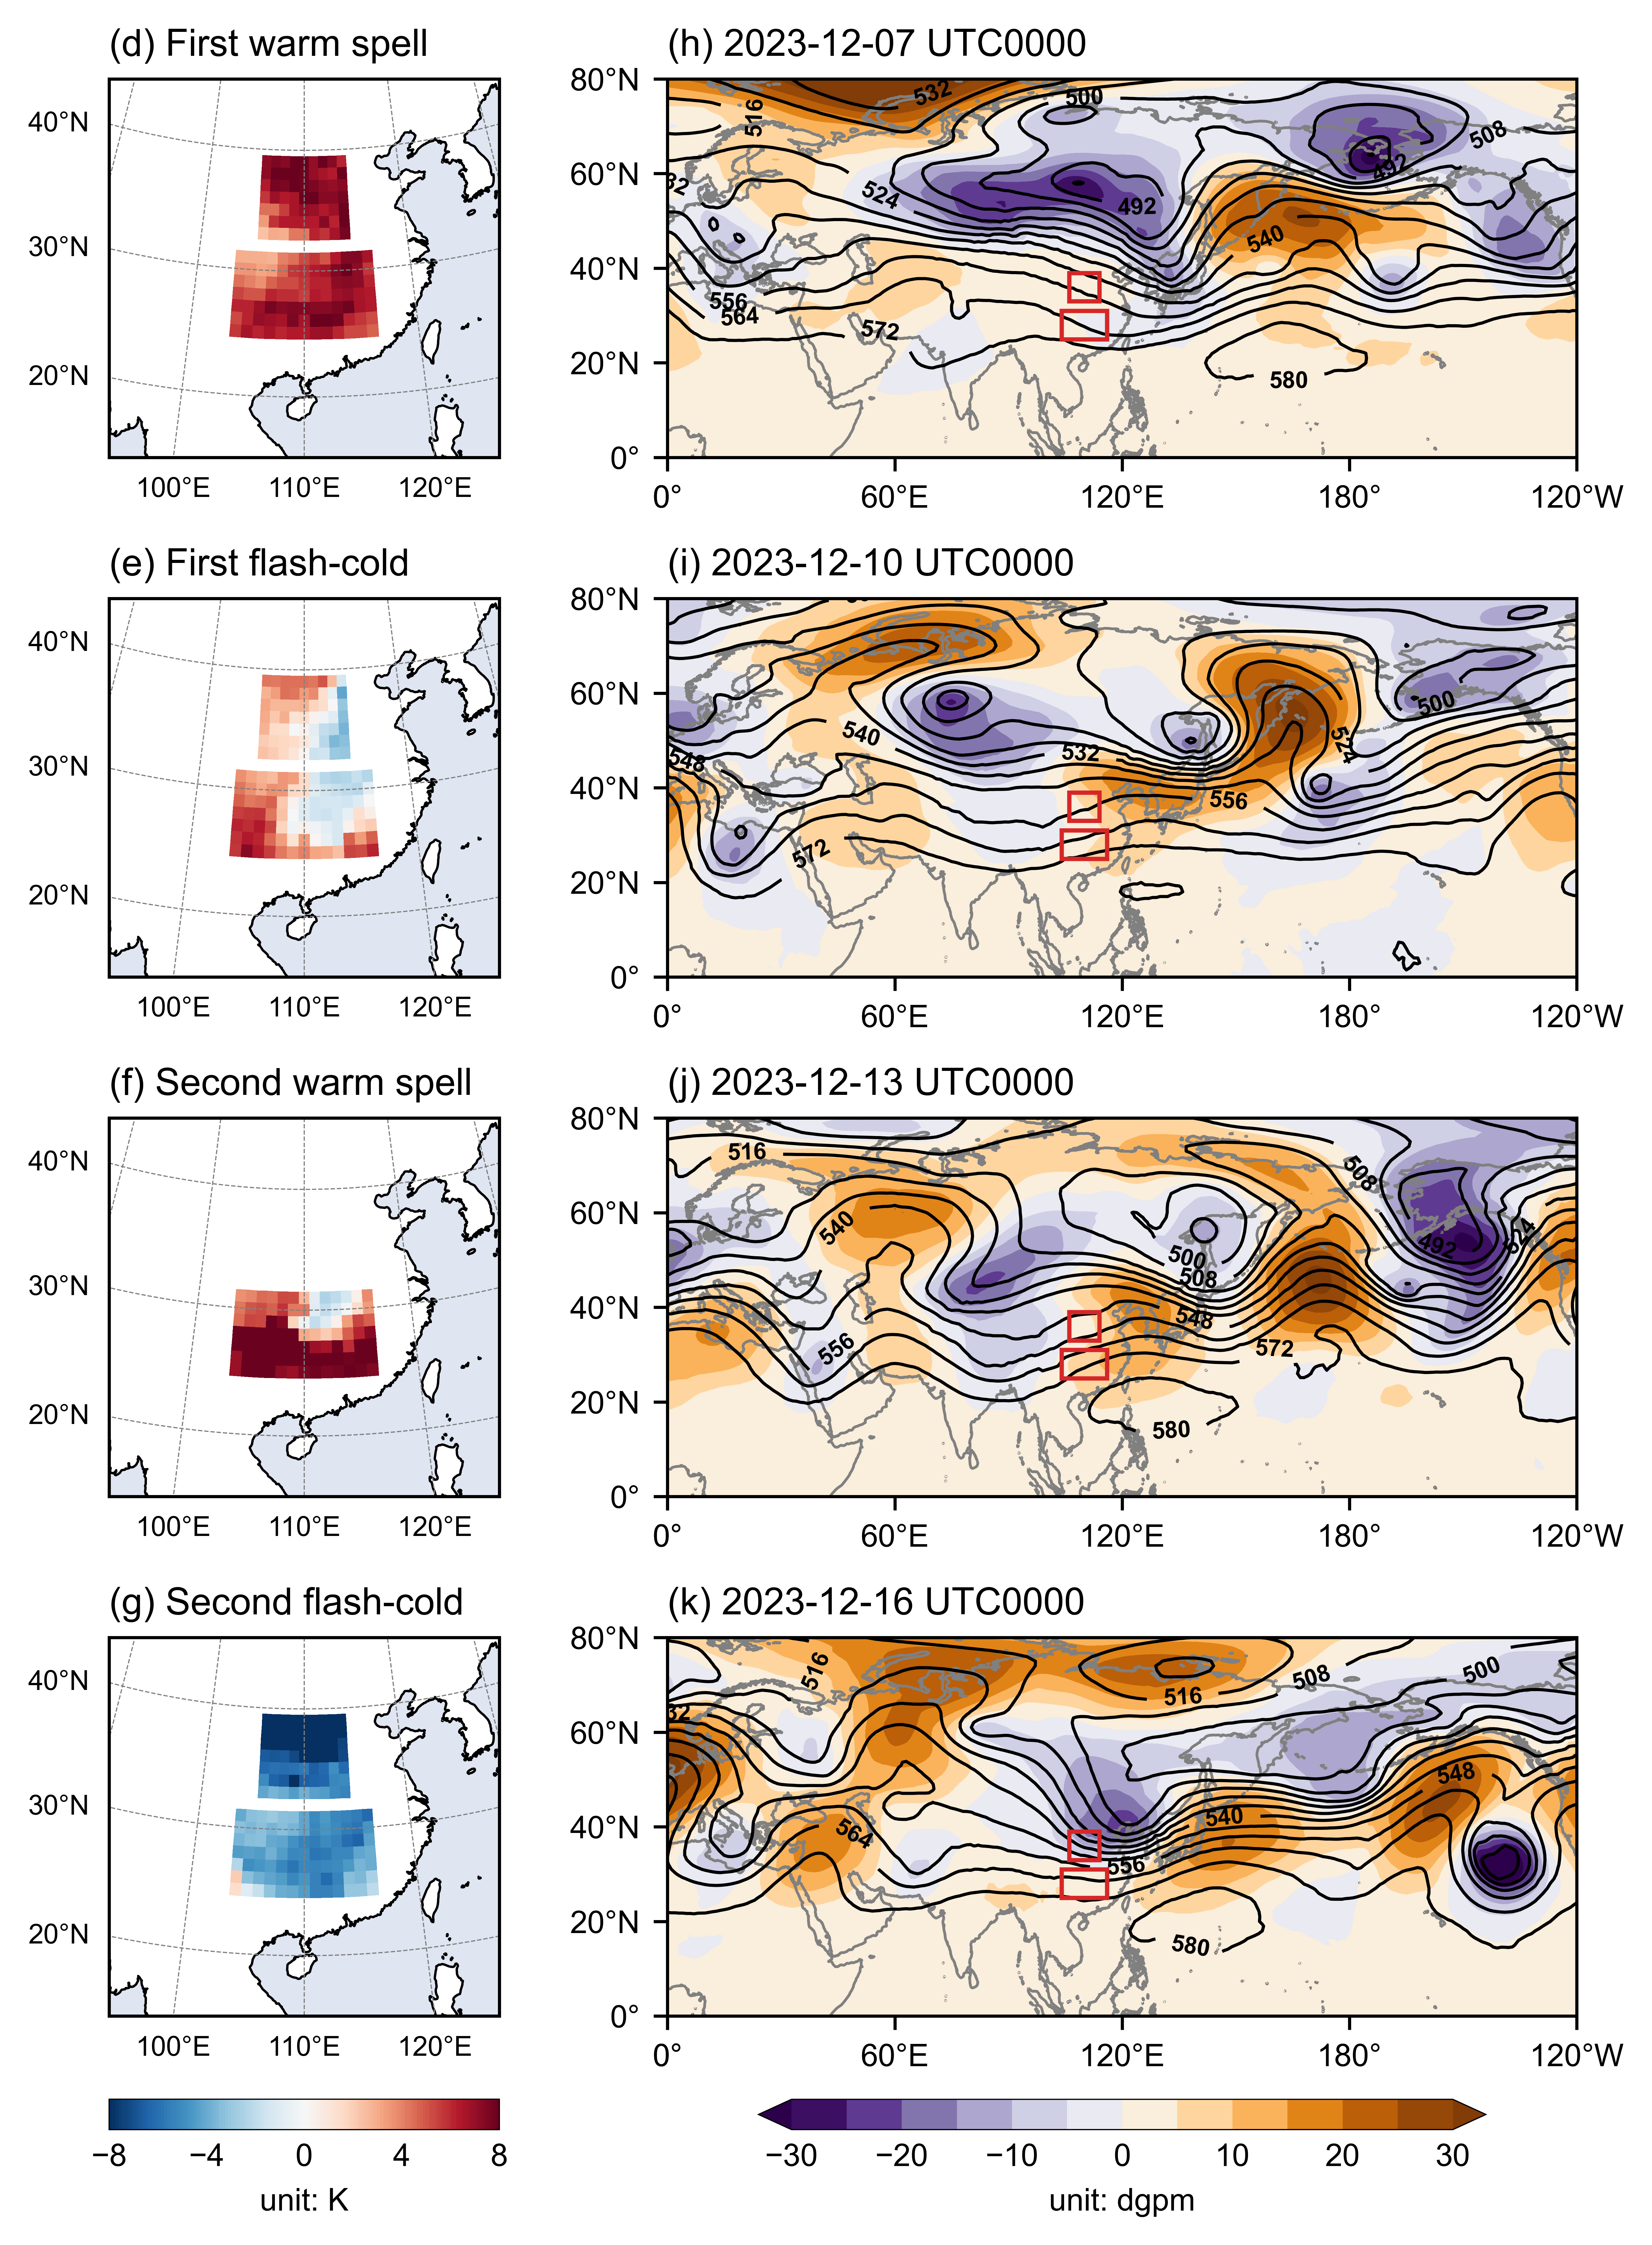

In [24]:
'''
-------------------------------------------------------------------------------------- 
Visualize the results
-------------------------------------------------------------------------------------- 
'''

fig, axs = plt.subplots(4, 2, figsize=(6,8), dpi=1000, gridspec_kw={'width_ratios':[1,2]})

t2m_ano_north_ls = [t2m_ano_north_warming1, t2m_ano_north_stage1, t2m_ano_north_warming2, t2m_ano_north_stage2]
t2m_ano_south_ls = [t2m_ano_south_warming1, t2m_ano_south_stage1, t2m_ano_south_warming2, t2m_ano_south_stage2]
title_ls = ['(d) First warm spell', '(e) First flash-cold', '(f) Second warm spell', '(g) Second flash-cold']

for ii,ax in enumerate(axs[:,0]):
    projection = ccrs.LambertConformal(central_longitude=110,central_latitude=45,standard_parallels=(30,60))
    data_ccrs = ccrs.PlateCarree()
    ax.axis('off')
    ax = fig.add_subplot(4, 2, (ii+1)*2-1, projection=projection)

    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), lw=0.6, edgecolor='black') 
    # ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='#f8f7e9') 
    ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='#dfe5f1') 
    ax.set_extent([95, 125, 15, 45], data_ccrs)

    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, linestyle='--', color='grey', linewidth=0.3, alpha=1)
    gl.right_labels = None
    # gl.left_labels = None
    gl.top_labels = None
    gl.rotate_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(110-90,110+90,10))
    gl.xlabel_style = {'size': 7}
    gl.ylocator = mticker.FixedLocator(np.arange(0,100,10))
    gl.ylabel_style = {'size': 7}

    ### T_ano ###
    if ii != 2:
        ax_pcolor = ax.pcolormesh(t2m_ano_north_ls[ii]['longitude'], t2m_ano_north_ls[ii]['latitude'], t2m_ano_north_ls[ii],
                        vmin=-8, vmax=8, cmap=cmaps.MPL_RdBu_r, transform=data_ccrs)
    ax_pcolor = ax.pcolormesh(t2m_ano_south_ls[ii]['longitude'], t2m_ano_south_ls[ii]['latitude'], t2m_ano_south_ls[ii],
                    vmin=-8, vmax=8, cmap=cmaps.MPL_RdBu_r, transform=data_ccrs)
    ax.set_title(title_ls[ii], loc='left')

ax_cb = ax.inset_axes([0, -0.3, 1, 0.08])                                   # create a subplot for colobar
#                                                                           # [left starting point, bottom starting point, length, width] unit:pixels
cb_detect = fig.colorbar(ax_pcolor, cax=ax_cb, orientation='horizontal', spacing='proportional')
cb_detect.ax.tick_params(axis='both', length=0)
cb_detect.outline.set_visible(True)
cb_detect.set_ticks(np.linspace(-8,8,5))
cb_detect.set_label('unit: K')
cb_detect.outline.set_linewidth(0.3) 


seq_ls = ['(h)', '(i)', '(j)', '(k)']

for ii,ax in enumerate(axs[:,1]):
    projection = ccrs.PlateCarree(central_longitude=180)
    data_ccrs = ccrs.PlateCarree()
    ax.axis('off')
    ax = fig.add_subplot(4, 2, (ii+1)*2, projection=projection)

    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), lw=0.7, edgecolor='gray') 

    ### Contourf of GZ500_UTC00_2023 ###
    var_contour, lon_cyclic = add_cyclic_point(GZ500_UTC00_2023[ii,:,:], coord=GZ500_UTC00_2023['longitude'])
    ax_GZ500 = ax.contour(lon_cyclic, GZ500_UTC00_2023['latitude'], var_contour/100, 
                            levels=np.arange(428,600,8), colors='black', linewidths=0.8, transform=data_ccrs)
    labels = ax.clabel(ax_GZ500, fontsize=6)
    for label in labels:
        label.set_fontweight('bold')
    
    ### Contour of GZ500_ano_UTC00_2023 ###
    var_contour, lon_cyclic = add_cyclic_point(GZ500_ano_UTC00_2023[ii,:,:], coord=GZ500_ano_UTC00_2023['longitude'])
    ax_GZ500_ano = ax.contourf(lon_cyclic, GZ500_ano_UTC00_2023['latitude'], var_contour/100,
                                                    levels=np.linspace(-30,30,13), cmap=cmaps.MPL_PuOr_r, extend='both', alpha=1, transform=data_ccrs)

    ### Two regions ###
    rectangle_north = patches.Rectangle((106, 33), 8, 6, edgecolor='tab:red', facecolor='none', lw=1.1, alpha=1, transform=data_ccrs, zorder=7)
    rectangle_south = patches.Rectangle((104, 25), 12, 6, edgecolor='tab:red', facecolor='none', lw=1.1, alpha=1, transform=data_ccrs, zorder=7)
    ax.add_patch(rectangle_north)
    ax.add_patch(rectangle_south)

    ##x-axis##
    dlon = 60
    xticks = np.arange(0, 360.1, dlon)
    ax.set_xticks(xticks, crs=ccrs.PlateCarree()) 
    ax.xaxis.set_major_formatter(LongitudeFormatter())  
    ##y-axis##
    dlat = 20
    yticks = np.arange(-80, 80.1, dlat)   
    ax.set_yticks(yticks, crs=ccrs.PlateCarree()) 
    ax.yaxis.set_major_formatter(LatitudeFormatter())   #将数字设置为纬度格式

    ##Set the extent of map###
    extent = [0, 240, 0, 80] 
    ax.set_extent(extent, crs=ccrs.PlateCarree())  
    ax.set_title(f'{seq_ls[ii]} {pd.to_datetime(GZ500_UTC00_2023[ii,:,:]["time"].values).strftime("%Y-%m-%d UTC%H%M")}', loc='left')
    
    ax.set_aspect('auto')


ax_cb = ax.inset_axes([0.1, -0.3, 0.8, 0.08])    #creat a subplot for colobar
#                                                 #[left starting point, bottom starting point, length, width] unit:pixels
cb_detect = fig.colorbar(ax_GZ500_ano, cax=ax_cb, orientation='horizontal', spacing='proportional',
            drawedges=False, shrink=1, aspect=13)
cb_detect.ax.tick_params(axis='both', length=0)
cb_detect.outline.set_visible(True)
cb_detect.set_ticks(np.linspace(-30,30,13)[::2])
cb_detect.set_label('unit: dgpm')
cb_detect.outline.set_linewidth(0.3) 


plt.tight_layout()
plt.savefig(f'./figure-2-2.jpg',
            bbox_inches='tight')
plt.show()



# 3. Merge two figures

In [17]:
from PIL import Image

# 打开两个图像
image1 = Image.open('figure-2-1.jpg')
image2 = Image.open('figure-2-2.jpg')

# 获取两个图像的尺寸
width1, height1 = image1.size
width2, height2 = image2.size

# 计算新图像的宽度和高度
new_width = width1 + width2
new_height = max(height1, height2)

# 创建一个新的透明背景图像，宽度为两个图像宽度之和，高度为两个图像高度中的最大值
new_image = Image.new('RGB', (new_width, new_height), (255,255,255))

# 计算第一个图像在新图像中的位置
x_offset1 = 0
y_offset1 = (new_height - height1) // 2

# 计算第二个图像在新图像中的位置
x_offset2 = width1
y_offset2 = (new_height - height2) // 2

# 将两个图像粘贴到新图像上
new_image.paste(image1, (x_offset1, y_offset1))
new_image.paste(image2, (x_offset2, y_offset2))

# 保存新图像
new_image.save('figure-2.jpg', quality=100)

# 显示新图像
new_image.show()


START /usr/bin/eog "/tmp/tmp35x93is3.PNG"



(eog:213868): Gtk-WARNING **: 11:07:51.543: cannot open display: 
